In [59]:
# External modules
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import re
from collections import Counter
import matplotlib.pyplot as plt
# Project modules
import filter

In [100]:
# FUNCTIONS


def get_artworks_df():
    artworks = pd.read_csv('../saatchi_artworks_info.csv')
    artworks.rename(columns=lambda x: x.title(), inplace=True)
    artworks = calculate_area_and_price_per_area(artworks)
    for column_name in ['Styles', 'Mediums', 'Subjects']:
        artworks[column_name] = artworks[column_name].apply(lambda x: [str(value.strip()) for value in x.split(',')])
    
    return artworks

def calculate_area_and_price_per_area(dataframe):
    # Iterate over the "Size" column
    df = dataframe.copy()
    for i, size in enumerate(dataframe['Size']):
        # Extract the dimensions using regular expression
        dimensions = re.findall(r'\d+(?:\.\d+)?', size)
        if len(dimensions) >= 2:
            # Extract the width and height dimensions
            try:
                width = float(dimensions[0])
                height = float(dimensions[1])
                total_area = width * height
                df.at[i, 'Size'] = total_area
            except:
                df.at[i, 'Size'] = 'NaN'
    df['Price / in²'] = df['Price'] / df['Size']

    return df

def get_unique_values(df, column_name):
    # Extract all unique styles from the column
    unique_values = set()
    for styles in df[column_name]:
        if isinstance(styles, str):
            styles_list = [style.strip() for style in styles.split(',')]
            unique_values.update(styles_list)
    
    return unique_values

def check_columns(df, columns_names):
    for column in columns_names:
        df[column] = df[column].str.title()
        unique_list = get_unique_values(df, column)
        print(column, len(unique_list), 'unique values')

def restart_df(dataframe):
    df = calculate_area_and_price_per_area(dataframe)
    df = df[['Styles', 'Mediums', 'Subjects', 'Artist', 'Size', 'Price']]
    df = df.dropna(subset='Styles')
    columns_names = ['Styles', 'Mediums', 'Subjects']

    # Turn the "Styles" column into a list of strings
    for column in columns_names:
        column_serie = df[column].apply(lambda x: x.split(','))
        df[column] = column_serie
        return df

## CLEAN DATA

def remove_words_from_list(lst, words_to_remove):
    return [word for word in lst if word not in words_to_remove]


## OOOOLD
def fix_column(dataframe, column_name, fix_dict, remove_list, split_list):
    # Remove whitespaces from the beginning and end of each string
    dataframe[column_name] = dataframe[column_name].apply(lambda lst: [item.strip() for item in lst])
    # Change '-' to whitespaces in each string
    dataframe[column_name] = dataframe[column_name].apply(lambda lst: [item.replace('-', ' ') for item in lst])
    # Capitalize each string
    dataframe[column_name] = dataframe[column_name].apply(lambda lst: [item.title() for item in lst])
    # Remove ' Art' and ' Painting' from the end of each string
    dataframe[column_name] = dataframe[column_name].apply(lambda lst: [style.replace(' Art', '') for style in lst])
    dataframe[column_name] = dataframe[column_name].apply(lambda lst: [style.replace(' Painting', '') for style in lst])
    # Splits items present the split_list into separate items
    dataframe[column_name] = dataframe[column_name].apply(lambda lst: [item for item in lst if item not in split_list] + [item for item in lst for split_item in split_list if split_item in item])
    return dataframe


## NEEEW
def fix_based_on_dict(column, fix_dict):
    column = column.apply(lambda lst: [next((key for key, values in fix_dict.items() if item in values), item) for item in lst])
    return column

def remove_words_from_column(column, remove_list):
    column = column.apply(lambda lst: remove_words_from_list(lst, remove_list))
    return column


def get_occurrence_count_on_col_dict(values):
    # Get all unique values from the column
    occurrences_counts_dict = dict(Counter(values))
    print(occurrences_counts_dict)
    return occurrences_counts_dict

## LINEAR REGRESSIONS
    
def get_linear_regression(x, y):
    # Create a LinearRegression object
    linear_regression = LinearRegression()
    # train a model to predict the price of an artwork based on its size (use 0.3 as the test_size)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    linear_regression.fit(X_train, y_train)
    # Check coefficients and intercept of the model
    print('coeficient',linear_regression.coef_)
    print('intercept',linear_regression.intercept_)
    print('score', linear_regression.score(X_test, y_test))
    # predict the price of an artwork with a size of 1000 square inches
    # linear_regression.predict([[1000]])
    return linear_regression

def get_stats(dataframe, x, y):
    stats = {}
    for variable in [x, y]:
        max_variable = round(max(dataframe[variable]), 2)
        min_variable = round(min(dataframe[variable]), 2)
        mean_variable = round(dataframe[variable].mean(), 2)
        median_variable = round(dataframe[variable].median(), 2)
        stats_variable = {'Max': max_variable, 'Min': min_variable, 'Mean': mean_variable, 'Median': median_variable}
        # add stats_variable to stats
        stats[variable] = stats_variable
    return stats


def linear_regression_by_column(dataframe, x_column, y_column):
    x_artists = dataframe[[x_column]]
    y_artists = dataframe[[y_column]]
    # Create a LinearRegression object
    linear_regression = get_linear_regression(x_artists, y_artists)
    print('------')

In [109]:
artworks = get_artworks_df()
artworks = artworks[['Styles', 'Mediums', 'Subjects', 'Artist', 'Size', 'Price']]
artworks

,Styles,Mediums,Subjects,Artist,Size,Price
0,"[Figurative, Fine Art]",[Acrylic],[Beach],Victor Tkachenko,1200.0,3510.0
1,[Abstract],[Oil],[Abstract],Heurlier Cimolai Frėdėric,2559.03,6500.0
2,"[Illustration, Fine Art]","[Ink, Gold]",[Fashion],Bridget Davies Art,486.08,690.0
3,"[Conceptual, Figurative, Modern, Portraiture, ...",[Digital],[Women],Mallory Morrison,864.0,1930.0
4,"[Expressionism, Impressionism, Minimalism, Sur...",[Oil],[Dogs],Patty Rodgers,1200.0,2610.0
...,...,...,...,...,...,...
15995,"[Abstract Expressionism, Abstract, Minimalism]",[Oil],[Abstract],Francesco D'Adamo,2416.64,3450.0
15996,"[Figurative, Pop Art, Surrealism, Illustration]",[Risopraph],[Botanic],Yanin Ruibal,179.14,150.0
15997,"[Abstract, Conceptual, Minimalism]","[Acrylic, Gesso, resin]",[Abstract],Christian De Wulf,3385.2,6910.0
15998,[Figurative],[Photo],[Portrait],Naomi Vona,43.45,330.0


In [107]:
artworks['Sale_Status'].value_counts()

Sale_Status
forSale       15933
notForSale       36
soldOut          30
reserved          1
Name: count, dtype: int64

In [93]:
## SEGMENT AND CLEAN DATA

artworks_data = get_artworks_df()
## COLUMN CHOSEN TO DEFINE SEGMENTS
column_name = 'Styles'
column = artworks_data.Styles

column = fix_based_on_dict(column, filter.fix_styles)

segments_in_column_list = [value for sublist in column for value in sublist]

# ## Filter segments based on #Occurences
occurrences_threshold = 200
occurrence_count_on_col_dict = get_occurrence_count_on_col_dict(segments_in_column_list)
print(occurrence_count_on_col_dict)

# Remove rows that have [] in column
filtered_artworks_data = artworks_data[column.apply(lambda x: len(x) > 0)]
filtered_artworks_data = filtered_artworks_data.dropna(subset=['Price', 'Size'])
filtered_artworks_data[column_name] = column

{'Figurative': 4049, 'Fine Art': 6538, 'Abstract': 8063, 'Illustration': 1073, 'Conceptual': 2365, 'Modernism': 6354, 'Portraiture': 1915, 'Surrealism': 1567, 'Expressionism': 3445, 'Impressionism': 2102, 'Minimalism': 2635, 'Cubism': 433, 'Street Art': 920, 'Pop Art': 1917, 'Realism': 1602, 'Abstract Expressionism': 4410, 'Contemporary': 1998, '#informal': 1, 'Folk': 241, 'Dadaism': 273, 'Digital': 12, 'Art Deco': 1131, 'Optical': 15, 'Documentary': 824, 'Photorrealism': 830, 'Plein Air': 7, 'Tonalist': 6, 'deconstructuvist': 1, 'geometric': 24, 'Modern Abstract': 24, 'still life': 3, 'Informalism': 4, 'Abstract realism': 2, 'Oil on Linen': 2, 'Generative': 26, 'Hudson River School': 2, 'geometric abstraction': 3, '3d Sculpture': 46, 'portrait': 2, 'Semi Abstract': 4, 'Magical Realism': 6, 'Gestural Abstraction': 3, 'blackandwhite': 2, 'Arte Povera': 2, 'Collage': 8, 'Fractal/algorithmic': 20, 'Glitch': 8, 'Pattern': 3, 'Industrial': 1, 'Generative art': 4, 'form': 1, 'linear': 2, 'mi

In [98]:
## CONSOLIDATING SEGMENTED DATA

# New dataframe for each style in styles_filtered_by_threshold
segments_dfs = {}
for key, value in occurrence_count_on_col_dict.items():
    if value > occurrences_threshold:
        segments_dfs[key] = filtered_artworks_data[filtered_artworks_data[column_name].apply(lambda x: key in x)]

# New dataframe with unique segments as index and MeanPrice, MedianPrice, MeanSize, MedianSize as columns
all_styles_df = pd.DataFrame(index=segments_dfs.keys(), columns=['MeanPrice', 'MedianPrice', 'MeanSize', 'MedianSize', 'MeanPricePerIn²', 'MedianPricePerIn²', 'Count'])
# Populate dataframe with mean price, median price, mean size and median size for each segment
for key, value in segments_dfs.items():
    all_styles_df.loc[key, 'MeanPrice'] = value['Price'].mean().round(0)
    all_styles_df.loc[key, 'MedianPrice'] = value['Price'].median().round(0)
    all_styles_df.loc[key, 'MeanSize'] = value['Size'].mean().round(0)
    all_styles_df.loc[key, 'MedianSize'] = value['Size'].median().round(0)
    all_styles_df.loc[key, 'MeanPricePerIn²'] = value['Price / in²'].mean().round(2)
    all_styles_df.loc[key, 'MedianPricePerIn²'] = value['Price / in²'].median().round(2)
    all_styles_df.loc[key, 'Count'] = len(value)


all_styles_df.sort_values(by='MeanPrice', ascending=False, inplace=True)
all_styles_df = all_styles_df[all_styles_df['Count'] > 500]
all_styles_df

,MeanPrice,MedianPrice,MeanSize,MedianSize,MeanPricePerIn²,MedianPricePerIn²,Count
Photorrealism,7968.0,2790.0,2343.0,1487.0,3.93,3.4,825
Documentary,6521.0,1288.0,1715.0,751.0,4.84,3.71,822
Realism,5317.0,2100.0,1522.0,729.0,4.83,3.26,1597
Minimalism,3760.0,1780.0,1546.0,1024.0,2.91,1.93,2627
Modernism,3569.0,1680.0,1488.0,916.0,3.23,2.05,6336
Abstract,3352.0,1820.0,1490.0,1087.0,2.97,2.02,8041
Surrealism,3209.0,1570.0,1251.0,740.0,4.43,2.57,1566
Pop Art,3053.0,1660.0,1189.0,900.0,3.65,2.13,1914
Conceptual,2979.0,1600.0,1473.0,838.0,5.15,2.1,2365
Abstract Expressionism,2929.0,1814.0,1434.0,1194.0,2.82,1.88,4400


Impressionism size: (2095, 46)
Impressionism stats: {'Size': {'Max': 223161.76, 'Min': 15.21, 'Mean': 1057.35, 'Median': 556.96}, 'Price': {'Max': 85777.0, 'Min': 135.0, 'Mean': 2331.1, 'Median': 1230.0}}
coeficient [[0.0623057]]
intercept [2207.17401829]
score 0.007468083720734042
------
Photorrealism size: (825, 46)
Photorrealism stats: {'Size': {'Max': 149963.84, 'Min': 24.0, 'Mean': 2343.2, 'Median': 1486.8}, 'Price': {'Max': 101000.0, 'Min': 145.0, 'Mean': 7968.0, 'Median': 2790.0}}
coeficient [[3.46362693]]
intercept [326.80008106]
score -12.257592654562036
------


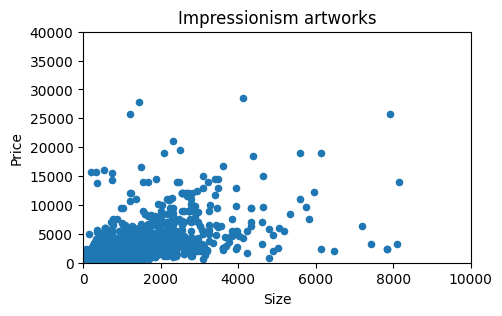

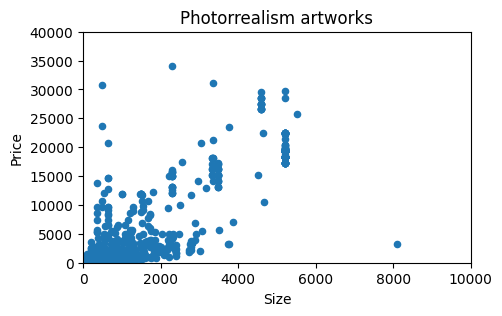

In [110]:
## TEST LINEAR REGRESSIONS: SEGMENT X ALL ARTWORKS

segment1 = 'Impressionism'
segment2 = 'Photorrealism'

# Variables
x = 'Size'
y = 'Price'

segments = [segment1, segment2]

for segment in segments:
    if segment == 'All':
        segment_df = filtered_artworks_data
    else:
        segment_df = segments_dfs[segment]

    print(segment + ' size:',segment_df.shape)
    print(segment + ' stats:', get_stats(segment_df, x, y))

    xlim = (0, 10000)
    ylim = (0, 40000)

    segment_df.plot.scatter(x=x, y=y, title=segment+' artworks', figsize=(5, 3), xlim=xlim, ylim=ylim)
    linear_regression_by_column(segment_df, x, y)


In [6]:
## ARTISTS

def get_artists_df():
    agg_df = artworks.dropna(subset=['Price'])
    agg_data = agg_df.groupby('Artist').agg({'Artist': 'count',
                                            'Price': ['mean', lambda x: x.std(skipna=False)],
                                            'Price / in²': ['mean', lambda x: x.std(skipna=False)],
                                            'Size': ['mean', lambda x: x.std(skipna=False)]})
    agg_data = agg_data.reset_index()

    # Flatten the column names
    agg_data.columns = ['Artist', 'NumArtworks', 'MeanPrice', 'StdPrice', 'MeanPricePerInch', 'StdPricePerInch', 'MeanSize', 'StdSize']

    # Create a new DataFrame with the aggregated data from artworks_info
    artists_from_artworks = pd.DataFrame(agg_data)
    artists_from_artworks = artists_from_artworks[artists_from_artworks['NumArtworks'] >= 3]
    # Get artists data from artists_info
    artists_from_artists = pd.read_json('../saatchi_artists_info.json')
    artists_from_artists.rename(columns=lambda x: x.title(), inplace=True)
    artists_from_artists.rename(columns={'Name': 'Artist'}, inplace=True)

    # New dataframe with all artists that are contained in both dataframes
    artists_from_artists = artists_from_artists[artists_from_artists['Artist'].isin(artists_from_artworks['Artist'])]
    artists = pd.merge(artists_from_artworks, artists_from_artists, on='Artist')

    return artists


artists = get_artists_df()
artists.columns

Index(['Artist', 'NumArtworks', 'MeanPrice', 'StdPrice', 'MeanPricePerInch',
       'StdPricePerInch', 'MeanSize', 'StdSize', 'Link', 'Location',
       'Followers_Count', 'Artworks_Count', 'Badges', 'Info', 'Events',
       'Exhibitions', 'Education'],
      dtype='object')

In [7]:
## LINEAR REGRESSIONS BY COLUMN

columns_names = ['MeanPrice', 'StdPrice',
           'MeanPricePerInch', 'StdPricePerInch',
           'MeanSize', 'StdSize',
           'Followers_Count', 'Artworks_Count', 'Badges']

y_column = 'MeanPricePerInch'

artists_to_model = artists[columns_names].dropna(subset=['MeanPrice'])

badges_to_model = artists_to_model['Badges'].str.join(',').str.get_dummies(sep=',')
artists_to_model = pd.concat([artists_to_model, badges_to_model], axis=1)

print(artists_to_model.columns)
columns_names.extend(badges_to_model.columns)
columns_names.remove(y_column)
columns_names.remove('Badges')

for column_name in columns_names:
    print(column_name)
    linear_regression_by_column(artists_to_model, column_name, y_column)

Index(['MeanPrice', 'StdPrice', 'MeanPricePerInch', 'StdPricePerInch',
       'MeanSize', 'StdSize', 'Followers_Count', 'Artworks_Count', 'Badges',
       'Artist featured in a collection', 'Featured in Inside The Studio',
       'Featured in One to Watch', 'Featured in Rising Stars',
       'Featured in the Catalog', 'NFT Artist',
       'Showed at the The Other Art Fair'],
      dtype='object')
MeanPrice
coeficient [[0.00167346]]
intercept [-1.11993991]
score -0.4272030531956448
------
StdPrice
coeficient [[0.00073859]]
intercept [2.1284408]
score 0.05061289540366831
------
StdPricePerInch
coeficient [[0.41174577]]
intercept [2.54118905]
score 0.8169815019919635
------
MeanSize
coeficient [[-0.00231124]]
intercept [7.22828254]
score -0.10817475240505736
------
StdSize
coeficient [[-0.00182618]]
intercept [5.65591858]
score -0.17411376485807528
------
Followers_Count
coeficient [[0.00061852]]
intercept [4.15246509]
score -0.21391740274899718
------
Artworks_Count
coeficient [[-0.00310

In [8]:
# decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

x_column = 'StdSize'

# Create a DecisionTreeRegressor object
decision_tree = DecisionTreeRegressor(random_state=42)
# Train the model
decision_tree.fit(X_train, y_train)
# Check the score of the model
print(decision_tree.score(X_test, y_test))
# Check the mean absolute error of the model
print(mean_absolute_error(y_test, decision_tree.predict(X_test)))
# Predict the price of an artwork with a size of 1000 square inches
# decision_tree.predict([[1000]])

NameError: name 'X_train' is not defined